<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Fastai%2BTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Started

In [1]:
!pip install transformers

     |████████████████████████████████| 368kB 4.8MB/s 
     |████████████████████████████████| 860kB 49.3MB/s 
     |████████████████████████████████| 1.0MB 64.5MB/s 
     |████████████████████████████████| 645kB 68.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=41ef66467006e2a3aaa65b145cf765dc29861714bb4650646bc1e96d9b704fc5
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import fastai
import transformers
print(f'fastai version: {fastai.__version__}')
print(f'transformers version: {transformers. __version__}')

fastai version: 1.0.59
transformers version: 2.2.1


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import os

import torch
import torch.optim as optim

import random

# fastai
from fastai import *
from fastai.text import *
from fastai.callback import *

# transformer
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig 

In [3]:
torch.cuda.is_available()

True

## Loading the Data

In [0]:
data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"
data = pd.read_csv(data_path)

In [0]:
data.head(2)

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."


In [0]:
# create the binary label
data['label'] = np.where(data['Score'] > 3, '1', '0')

# change score into categorical so it can be the multiclass label
data['Score'] = data['Score'].astype('category')


In [6]:
data.sample()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,label
86677,B001FOXYR6,A3J2HADAU4C299,We'll always have Paris,5,1,480074,Phil Scott,1,1279324800,"During the winter of 2008 I lived in Paris, su...",1


In [0]:
# split the data by timestamp
timesplit = data['Time'].quantile(0.8)

In [8]:
train = data[data['Time'] < timesplit]
test = data[data['Time'] >= timesplit]
train.shape, test.shape

((79992, 11), (20008, 11))

## FASTAI

In [168]:
%%time
# prep lm tuning data
data_lm = (TextList.from_df(data.loc[:, ['Text']], cols='Text')
            .split_by_rand_pct(0.1, seed=1234)
            .label_for_lm()
            .databunch(bs=bs))

CPU times: user 5.41 s, sys: 1.64 s, total: 7.05 s
Wall time: 1min 10s


In [169]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


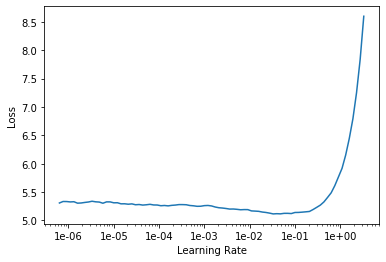

In [170]:
learner.lr_find()
learner.recorder.plot()

In [171]:
learner.fit_one_cycle(1, 1e02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.131574,6.065863,0.088210,23:02


In [172]:
learner.unfreeze()
learner.fit_one_cycle(3, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.672173,4.310875,0.265734,26:55


KeyboardInterrupt: ignored

In [0]:
learner.save('learner_ft')

In [0]:
learner.save_encoder('learner_encoder')

In [176]:
data_clas = (TextList.from_df(train, cols='Text', vocab=data_lm.vocab)
            .split_by_rand_pct(0.1, seed=1234)
            .label_from_df(cols=['label'])
            .databunch(bs=bs))

In [0]:
learner=text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, AUROC()])
learner.load_encoder('learner_encoder');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


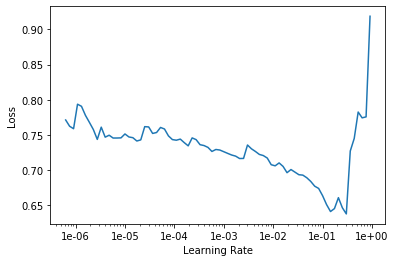

In [180]:
learner.lr_find()
learner.recorder.plot()

In [182]:
learner.fit_one_cycle(1, 1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.427691,2.042626,0.814602,0.838578,10:59


## FASTAI + TRANSFORMER

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
seed = 42
use_fp16 = False
bs = 4 # 4 for roberta/distibert/xlm

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

model_type = 'xlm'
pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [143]:
# all the pretrained model for the specific model_class
model_class.pretrained_model_archive_map

{'xlm-clm-ende-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-clm-ende-1024-pytorch_model.bin',
 'xlm-clm-enfr-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-clm-enfr-1024-pytorch_model.bin',
 'xlm-mlm-100-1280': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-100-1280-pytorch_model.bin',
 'xlm-mlm-17-1280': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-17-1280-pytorch_model.bin',
 'xlm-mlm-en-2048': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-en-2048-pytorch_model.bin',
 'xlm-mlm-ende-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-ende-1024-pytorch_model.bin',
 'xlm-mlm-enfr-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-enfr-1024-pytorch_model.bin',
 'xlm-mlm-enro-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-enro-1024-pytorch_model.bin',
 'xlm-mlm-tlm-xnli15-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-tlm-xnli15-1024-p

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

### 1 Setup FASTAI Databunch

In [0]:
# load the pretrained tokenizer
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)

In [146]:
transformer_tokenizer.max_len

512

###### Create Custom FASTAI TOKENIER from pretrained transformer tokenizer

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [149]:
tokenizer_class.pretrained_vocab_files_map

{'merges_file': {'xlm-clm-ende-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-ende-1024-merges.txt',
  'xlm-clm-enfr-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-enfr-1024-merges.txt',
  'xlm-mlm-100-1280': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-100-1280-merges.txt',
  'xlm-mlm-17-1280': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-17-1280-merges.txt',
  'xlm-mlm-en-2048': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-en-2048-merges.txt',
  'xlm-mlm-ende-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-ende-1024-merges.txt',
  'xlm-mlm-enfr-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-enfr-1024-merges.txt',
  'xlm-mlm-enro-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-enro-1024-merges.txt',
  'xlm-mlm-tlm-xnli15-1024': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlm-mlm-tlm-xnli15-1024-merges.txt',
  'xlm-mlm-xnli15-10

###### Create Custom FASTAI Vocab from the pretrained transformer tokenizer

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [0]:
fastai_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

###### Create Custom FASTAI Processor

In [0]:
numericalize_processor = NumericalizeProcessor(vocab=fastai_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


In [0]:
fastai_processor = [tokenize_processor, numericalize_processor]

###### Create Custom FASTAI Databunch

In [154]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)

[CLS] token : </s>
[SEP] token : </s>
[PAD] token : <pad>


In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [157]:
databunch = (TextList.from_df(train, cols='Text', processor=fastai_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [158]:
databunch.show_batch(10)

text,target
"recently</w> ,</w> my</w> husband</w> brought</w> home</w> one</w> can</w> of</w> sal t- free</w> sard ines</w> in</w> water</w> (</w> can</w> 't</w> remember</w> they</w> type</w> ,</w> but</w> none</w> of</w> the</w> brands</w> listed</w> here</w> )</w> .</w> i</w> had</w> been</w> watching</w> the</w> bb c</w> blue</w> planet</w> series</w> recently</w> ,</w> and</w> all</w> that</w> footage</w> of</w> sard ine</w> fe asting</w> by</w> the</w> various</w> ocean</w> predators</w> must</w> have</w> lodged</w> somewhere</w> in</w> my</w> sub consciousness</w> ,</w> because</w> i</w> eyed</w>",1
"i</w> love</w> the</w> just</w> cheese</w> bars</w> .</w> it</w> 's</w> basically</w> just</w> cris ped</w> cheese</w> ,</w> some</w> of</w> which</w> have</w> pow dered</w> flav oring</w> mixed</w> in</w> .</w> this</w> one</w> is</w> pizza</w> fl avored</w> ,</w> which</w> i</w> also</w> liked</w> .</w> <</w> b r</w> /</w> ></w> <</w> b r</w> /</w> ></w> you</w> can</w> do</w> this</w> yourself</w> in</w> just</w> a</w> few</w> minutes</w> by</w> putting</w> a</w> little</w> oil</w> (</w> or</w> p am</w> )</w> on</w> aluminum</w>",0
"a</w> little</w> over</w> a</w> week</w> ago</w> and</w> completely</w> out</w> of</w> the</w> blue</w> ,</w> i</w> started</w> having</w> heart</w> pal pit ations</w> .</w> i</w> 'm</w> a</w> 27-year-old</w> female</w> and</w> am</w> on</w> no</w> medications</w> and</w> have</w> no</w> significant</w> medical</w> history</w> .</w> the</w> first</w> two</w> days</w> ,</w> i</w> only</w> noticed</w> a</w> few</w> of</w> them</w> .</w> then</w> for</w> the</w> next</w> 3</w> days</w> ,</w> i</w> had</w> them</w> much</w> more</w> frequently</w> .</w> i</w> could</w> put</w> my</w> fingers</w>",1
"i</w> 've</w> tried</w> several</w> of</w> the</w> d m r f</w> soup</w> and</w> products</w> .</w> some</w> of</w> the</w> sou ps</w> were</w> pretty</w> bl and</w> and</w> not</w> worth</w> re purchasing</w> .</w> some</w> i</w> liked</w> quite</w> a</w> bit -- the</w> split</w> pe a</w> ,</w> the</w> spring</w> onion</w> ,</w> the</w> box ed</w> vegetable</w> ,</w> for</w> example</w> .</w> this</w> instant</w> soup</w> from</w> the</w> line</w> is</w> the</w> best</w> .</w> i</w> like</w> it</w> even</w> more</w> than</w> then</w>",1


In [159]:
databunch.one_batch()[0].shape

torch.Size([4, 512])

### 2 Setup FASTAI Learner 

###### Create Custom Transformer Model

In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [161]:
config = config_class.from_pretrained(pretrained_model_name)
config

100%|██████████| 396/396 [00:00<00:00, 62272.96B/s]


{
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "causal": false,
  "dropout": 0.1,
  "emb_dim": 1024,
  "embed_init_std": 0.02209708691207961,
  "end_n_top": 5,
  "eos_index": 1,
  "finetuning_task": null,
  "gelu_activation": true,
  "id2lang": {
    "0": "en",
    "1": "fr"
  },
  "init_std": 0.02,
  "is_decoder": false,
  "is_encoder": true,
  "lang2id": {
    "en": 0,
    "fr": 1
  },
  "layer_norm_eps": 1e-12,
  "mask_index": 5,
  "max_position_embeddings": 512,
  "max_vocab": -1,
  "min_count": 0,
  "n_heads": 8,
  "n_langs": 2,
  "n_layers": 6,
  "n_words": 64139,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_index": 2,
  "pruned_heads": {},
  "same_enc_dec": true,
  "share_inout_emb": true,
  "sinusoidal_embeddings": false,
  "start_n_top": 5,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "first",
  "summary_use_proj": true,
  "

In [162]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

100%|██████████| 830122454/830122454 [00:20<00:00, 41321947.95B/s]


###### Create FASTAI Learner Model

In [0]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy, AUROC()])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [164]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 1024]          524,288    True      
______________________________________________________________________
Embedding            [512, 1024]          65,678,336 True      
______________________________________________________________________
LayerNorm            [512, 1024]          2,048      True      
______________________________________________________________________
Linear               [512, 1024]          1,049,600  True      
______________________________________________________________________
Linear               [512, 1024]          1,049,600  True      
______________________________________________________________________
Linear               [512, 1024]          1,049,600  True      
______________________________________________________________________
Linear               [512, 1024]          1,049,600  True      
_______________________________________

###### Training FASTAI Learner 

In [165]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-05


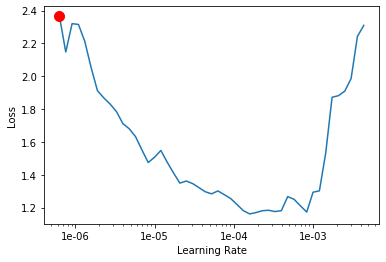

In [166]:
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.281954,0.274387,0.881110,0.928083,26:30


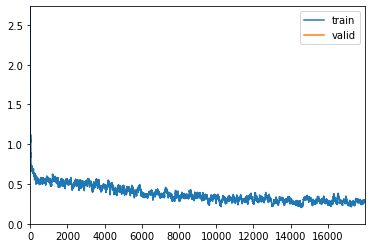

In [167]:
# result for xlm
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.185406,0.161862,0.938242,0.974768,16:45


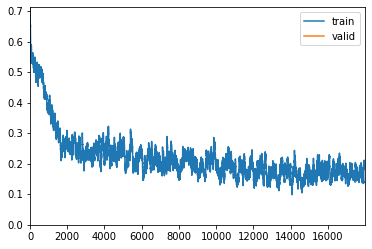

In [67]:
# result for Distilbert
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.133809,0.136281,0.950119,0.982782,31:11


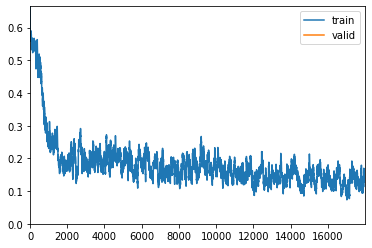

In [37]:
# result for roberta
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

In [38]:
learner.show_results(rows=5)

text,target,prediction
"<s> ĠI 've Ġordered Ġthis Ġcoffee Ġseveral Ġtimes Ġ& Ġit Ġhas Ġbeen Ġexcellent Ġevery Ġtime . Ġ ĠIt 's Ġnot Ġover - ro asted / bur nt Ġtasting Ġ& Ġthe Ġflavor Ġis Ġvery Ġcomplex . Ġ ĠThe Ġbeans Ġare Ġoily , Ġblack Ġ& ĠI Ġfound Ġno Ġqu akers Ġ( under developed Ġcoffee Ġbeans Ġthat Ġmake Ġcoffee Ġtaste Ġawful Ġ- Ġthey Ġstick Ġout Ġbecause Ġthey Ġdo Ġnot Ġroast / dark en",1,1
"<s> ĠMy Ġ7 Ġmonth Ġold ĠL OV ES Ġreal Ġfood Ġand Ġthe Ġnew Ġorganic Ġfoods Ġon Ġthe Ġmarket Ġhave Ġbeen Ġa Ġgod 's Ġsend . Ġ ĠI Ġbought Ġa Ġbox Ġof Ġthe ĠSweet ĠGinger ĠChicken Ġw / ĠBan anas Ġ& ĠCoconut Ġbased Ġon Ġthe Ġreviews Ġand Ġthe Ġoverall Ġappeal Ġof Ġthe Ġname . Ġ ĠWe Ġare Ġnow Ġfeeding Ġthem Ġto Ġour Ġdog , Ġwhich Ġis Ġappropriate Ġbecause Ġit Ġlooks ,",0,1
"<s> ĠK EEP ĠYOUR ĠREC E IP T . ĠThe Ġproduct Ġis ĠNAS TY ... The Ġproduct Ġis Ġguaranteed ... but Ġthe Ġprocess Ġto Ġget Ġa Ġrefund Ġis Ġon erous Ġ( in Ġmy Ġopinion ). < br Ġ/ >< br Ġ/> "" I Ġam Ġsorry Ġthat Ġyou Ġwere Ġnot Ġsatisfied Ġwith Ġour ĠMayo . Ġ ĠPlease Ġsend Ġa Ġproof Ġof Ġpurchase , Ġa Ġnote Ġwith Ġthe Ġexpiration Ġdate Ġof Ġthe",0,0
"<s> ĠWe 've Ġgone Ġthrough Ġall Ġof Ġthe Ġflavors Ġnow Ġthree Ġtimes . Ġ ĠBoth Ġcats Ġch owed Ġdown Ġquite Ġhappily Ġon Ġthe Ġfood . Ġ ĠThe Ġboy Ġgot Ġquite Ġvocal Ġand Ġins istent Ġthe Ġnext Ġfew Ġdays Ġabout Ġhow Ġmuch Ġhe Ġwanted Ġmore Ġof Ġthe Ġwet Ġfood . Ġ ĠFar , Ġfar Ġmore Ġvocal Ġthan Ġhe Ġgot Ġafter Ġgetting Ġthe Ġ9 ĠLives Ġcanned Ġfood Ġbefore . Ġ ĠJudging Ġfrom",1,1


In [39]:
interp = learner.interpret(ds_type = DatasetType.Valid)
#txt_ci = TextClassificationInterpretation.from_learner(learner)

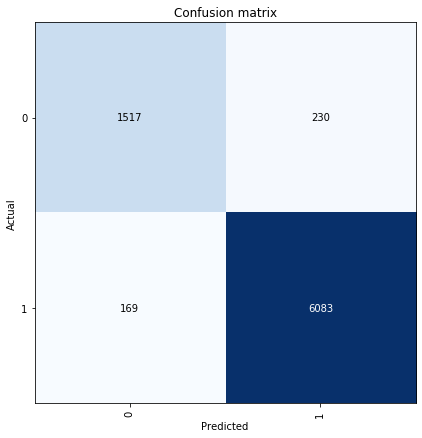

In [40]:
interp.plot_confusion_matrix(normalize=False,figsize=(6,6))

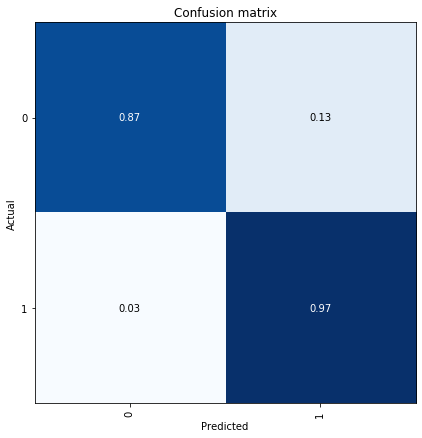

In [41]:
interp.plot_confusion_matrix(normalize=True,figsize=(6,6))

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
test['label'].value_counts()

1    15348
0     4660
Name: label, dtype: int64

In [0]:
learner.get_preds(databunch.test_dl)

[tensor([[0.9500, 0.0500],
         [0.0098, 0.9902],
         [0.2972, 0.7028],
         ...,
         [0.9730, 0.0270],
         [0.9730, 0.0270],
         [0.0108, 0.9892]]), tensor([0, 1, 1,  ..., 0, 0, 1])]

In [0]:
databunch.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fa866dcd9e8>, device=device(type='cuda'), tfms=[], collate_fn=functools.partial(<function pad_collate at 0x7fa86979a488>, pad_idx=0, pad_first=False, backwards=False))

### Reference
https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta